In [3]:
from HKZ_single_run import DESModel
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples

In [35]:
model = DESModel()
model.define_sites()
model.define_equipment()
model.resources(kind="response_motions")
model.processes()
model.start_simulation()

model1 = DESModel()
model1.define_sites()
model1.define_equipment()
model1.resources(kind="allowable_sea_state")
model1.processes()
model1.start_simulation()

In [36]:
observed = pd.read_csv("./data/raw/HKZ_installation_cycles_workability.csv", parse_dates=["StartDate", "ProjectLength", "Downtime"])

In [14]:
dates = pd.date_range(start=dt.datetime(1990, 1, 1), end=dt.datetime(2019, 1, 1), freq="H")
indices = np.random.randint(0, len(dates), size=10_000)
start_dates = dates[indices] 

In [38]:
results = dict(
    StartDate=start_dates, 
    ProjectDurationRAO=[], 
    DowntimeDurationRAO = [],
    ProjectDurationSea=[],
    DowntimeDurationSea = []
)

for date in tqdm(start_dates):
    model.restart_simulation(start_date=date)
    results["ProjectDurationRAO"].append(model.project_length())
    results["DowntimeDurationRAO"].append(model.get_downtime())

    model1.restart_simulation(start_date=date)
    results["ProjectDurationSea"].append(model1.project_length())
    results["DowntimeDurationSea"].append(model1.get_downtime())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [41]:
df = pd.DataFrame(results)
df["WorkabilityRAO"] = 1 - (df["DowntimeDurationRAO"] / df["ProjectDurationRAO"])
df["ProjectDurationRAO"] = df["ProjectDurationRAO"].dt.total_seconds() / (3600 * 24)

df["WorkabilitySea"] = 1 - (df["DowntimeDurationSea"] / df["ProjectDurationSea"])
df["ProjectDurationSea"] = df["ProjectDurationSea"].dt.total_seconds() / (3600 * 24)

df["Month"] = df["StartDate"].dt.month

In [42]:
tmp_df = df[df["WorkabilityRAO"] < 1]
tmp_df1 = df[df["WorkabilitySea"] < 1]
tmp_ob = observed[observed["Workability"] < 1]

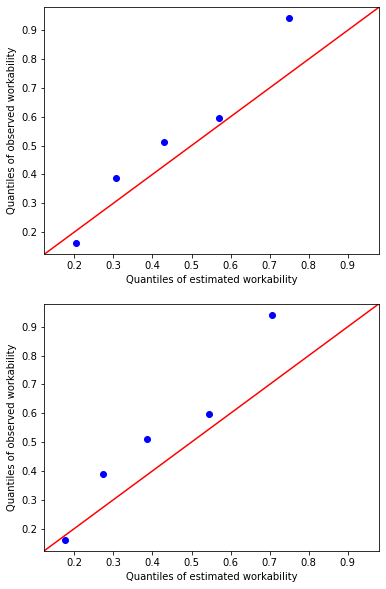

In [87]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

qqplot1 = qqplot_2samples(
    data2=tmp_df["WorkabilityRAO"],
    data1=tmp_ob["Workability"],
    xlabel="Quantiles of estimated workability",
    ylabel="Quantiles of observed workability",
    line="45",
    ax=ax[0]
)

qqplot2 = qqplot_2samples(
    data2=tmp_df1["WorkabilitySea"],
    data1=tmp_ob["Workability"],
    xlabel="Quantiles of estimated workability",
    ylabel="Quantiles of observed workability",
    line="45",
    ax=ax[1],
)